# k means ||

In [52]:
import matplotlib.pyplot as plt

In [2]:
# import the python libraries to create/connect to a Spark Session
from pyspark.sql import SparkSession

# build a SparkSession 
#   connect to the master node on the port where the master node is listening (7077)
#   declare the app name 
#   configure the executor memory to 512 MB
#   either *connect* or *create* a new Spark Context
spark = SparkSession.builder \
    .master("spark://spark-master:7077")\
    .appName("prova iniziale")\
    .config("spark.executor.memory", "512m")\
    .getOrCreate()

In [3]:
spark

In [4]:
# create a spark context
sc = spark.sparkContext

# print its status
sc

<SparkContext master=spark://spark-master:7077 appName=prova iniziale>

# Import data from sklearn (load in the disk)

This is going to be removed in the Cloud Veneto version


In [5]:
sc.setLogLevel("ERROR") # To hide warnings

In [6]:
!pip install scikit-learn # to be run at the launch of "docker compose up" 

     |████████████████████████████████| 10.9 MB 78 kB/s  eta 0:00:01
     |████████████████████████████████| 302 kB 19.9 MB/s eta 0:00:01
     |████████████████████████████████| 36.5 MB 53 kB/s s eta 0:00:01


In [7]:
import numpy as np
import pandas as pd
import random
import sklearn.datasets #va installato
import time

# from pyspark.sql.functions import sum
from pyspark.sql.functions import col
from pyspark.sql.functions import mean
from pyspark.sql.functions import stddev
from pyspark.sql.functions import rand
from pyspark.sql.functions import least
from pyspark.sql import Row
from pyspark.ml.feature import StandardScaler

In [8]:
# Hyperparameters
k = 4
G = 3 # Giosu factor
len_df = 494_021

In [9]:
# Import dataframe directly from sklearn
prova =  sklearn.datasets.fetch_kddcup99(percent10 = True, as_frame = True)
X = prova.data

In [10]:
n_cols = len(X.iloc[0])

In [11]:
n_cols = n_cols - 3 #because we will remove the binary variables

In [12]:
# Show the dataframe (to be deleted for a bigger dataframe) (TO BE DELETED)
X

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,b'tcp',b'http',b'SF',181,5450,0,0,0,0,...,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,0,b'tcp',b'http',b'SF',239,486,0,0,0,0,...,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,0,b'tcp',b'http',b'SF',235,1337,0,0,0,0,...,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0,b'tcp',b'http',b'SF',219,1337,0,0,0,0,...,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0,b'tcp',b'http',b'SF',217,2032,0,0,0,0,...,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,b'tcp',b'http',b'SF',310,1881,0,0,0,0,...,86,255,1.0,0.0,0.01,0.05,0.0,0.01,0.0,0.0
494017,0,b'tcp',b'http',b'SF',282,2286,0,0,0,0,...,6,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0
494018,0,b'tcp',b'http',b'SF',203,1200,0,0,0,0,...,16,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0
494019,0,b'tcp',b'http',b'SF',291,1200,0,0,0,0,...,26,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0


# Create a Spark dataframe
And then acquire important informations about the dataframe: # columns, # rows, # partitions, the schema, ...

In [13]:
# Create the spark dataframe with a smaller chunk of data (just to work easily)
X_smaller = X.iloc[random.sample(range(0, len(X.index)), len_df)]
spark_X = spark.createDataFrame(X_smaller)
spark_X.persist()

/usr/bin/spark-3.3.2-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/bin/spark-3.3.2-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


DataFrame[duration: bigint, protocol_type: binary, service: binary, flag: binary, src_bytes: bigint, dst_bytes: bigint, land: bigint, wrong_fragment: bigint, urgent: bigint, hot: bigint, num_failed_logins: bigint, logged_in: bigint, num_compromised: bigint, root_shell: bigint, su_attempted: bigint, num_root: bigint, num_file_creations: bigint, num_shells: bigint, num_access_files: bigint, num_outbound_cmds: bigint, is_host_login: bigint, is_guest_login: bigint, count: bigint, srv_count: bigint, serror_rate: double, srv_serror_rate: double, rerror_rate: double, srv_rerror_rate: double, same_srv_rate: double, diff_srv_rate: double, srv_diff_host_rate: double, dst_host_count: bigint, dst_host_srv_count: bigint, dst_host_same_srv_rate: double, dst_host_diff_srv_rate: double, dst_host_same_src_port_rate: double, dst_host_srv_diff_host_rate: double, dst_host_serror_rate: double, dst_host_srv_serror_rate: double, dst_host_rerror_rate: double, dst_host_srv_rerror_rate: double]

In [14]:
# Check the number of partitions the DataFrame is divided into the three workers yet
spark_X.rdd.getNumPartitions()

3

In [15]:
# Define a function that is able to select the single row in the dataframe
def getrows(df, rownums=None): # copied from the internet
    return df.rdd.zipWithIndex().filter(lambda x: x[1] in rownums).map(lambda x: x[0])

In [16]:
# Define the number of rows and columns in the dataframe
n_rows = len_df

In [17]:
# Delete the non-numerical values in an easy way
# clean_X = spark_X.select('*').drop('protocol_type', 'service', 'flag')
# clean_X.printSchema()

# Delete the non-numerical values in a reusable way
col_type = np.array(spark_X.dtypes)
types = col_type[:,1] 
colnames = col_type[:,0]
clean_X = spark_X.select([col(colnames[i]) for i in range(len(colnames)) if not types[i] == 'binary'])

# Step 0: Useful functions for the initialization

In [18]:
# Define the function for the distance between the cluster centers and the pandas dataframe
def distance(xrow, centers, num_cols=n_cols):
    '''Distance between a dataframe.row
    and the broadcasted value list of centers
    in the form of dataframe.row.value:
    
    broadC = sc.broadcast(center_rows).value
    xrow = clean_X.collect()[1]
    '''
    x = np.array(xrow)[:num_cols]
    the_ds = np.zeros(len(centers))
    
    for c in range(len(centers)):
        c_array = np.array(centers[c])[:num_cols]
        dist2 = np.linalg.norm(x - c_array)**2
        the_ds[c] = dist2
        
    return np.min(the_ds)

# Formula to evaluate the oversamping factor with the pre-factor G
def evaluate_l(log_phi, k, G):
    return G * k/log_phi # G = over-oversampling factor

# Function to select a row based on its probability
def select_row(x):
    if x > np.random.uniform(low = 0, high = 1):
        return True
    else:
        return False


### This is NOT $\Phi$. This is $log(\Phi)$. Pay attention budeo.

# Step 1: Choose a random sample from the dataset
This is the required step to begin the algorithm (doesn't need to be parallelized, since it is a select task)

In [19]:
# Choose the first sample randomly: select the random row
random_n = [np.random.randint(0, n_rows)]
random_sample = getrows(clean_X, random_n).collect()

# Step 2: Initial cost
Then we evaluate the cost function (sum of the squares after the first selection)

In [20]:
colnames = list(clean_X.dtypes[i][0] for i in range(len(clean_X.dtypes)))

In [21]:
# Add the colunm to keep the minimum distance between each point and the closest center
clean_X = (clean_X.select('*')
           .withColumn('minimum_cost', sum((col(colname)-random_sample[0][colname])**2 for colname in colnames)))

In [22]:
# Initial cost
initial_cost = np.log(clean_X.agg({"minimum_cost": "sum"}).collect()[0][0])
initial_cost

40.71877144988325

In [23]:
# Add the newly introduced value to the row that I selected in the first place
temp = random_sample[0].asDict()
temp["minimum_cost"] = 0.
random_sample[0] = Row(**temp)

In [24]:
# Broadcasting the row over the workers
bCent = sc.broadcast(random_sample)

# To show the content of the broadcast: b.value

## Step 2.5: evaluate number of iterations

After having evaluated $\log \phi$, we find a number of iterations which is of the same order of magnitude.

In [25]:
n_iter = int(initial_cost)
n_iter

40

# Step 3: For loop
Implement the for loop in order to evaluate probabilities and choose new centers



In [26]:
phi_iter = initial_cost
l = evaluate_l(phi_iter, k, G)
l

0.29470437276747474

In [27]:
%%time

i = 0
last_centers = 1
start_time = time.time()

while i < n_iter:   # or len(bCent.value) < k: # added as a safety condition (useless for very long datasets)

        '''
        Nel ciclo for:
            - Evaluate for each row l * d()^2 / phi
            - Sample with that probability
            - Broadcast centers to nodes
            - Evaluate new cost

        Ricordiamoci che distance è già al quadrato e che phi è il logaritmo
        '''

        # Evaluate the probability and select the new rows
        mod_phi = l/np.exp(phi_iter)
        new_rows = clean_X.select('*').withColumn('random_number', rand(seed=int(time.time())))\
                          .filter(col('random_number') < col('minimum_cost')*mod_phi).drop('random_number').collect()

        print("--- %s seconds ---" % (time.time() - start_time))
        start_time = time.time()
        
        # Update the broadcast in a non-usual way (newest at the beginning)
        bCent = sc.broadcast(new_rows + bCent.value)
        
        print("--- %s seconds ---" % (time.time() - start_time))
        start_time = time.time()

        # Update the minimum distance
        if len(new_rows) == 1:
            clean_X = clean_X.select('*').\
                      withColumn('minimum_cost', least('minimum_cost', sum((col(colname)-bCent.value[0][colname])**2 for colname in colnames) )).cache()

        elif len(new_rows) > 1:
            clean_X = clean_X.select('*').withColumn('dummy', least(*[sum((col(colname)-bCent.value[center][colname])**2 for colname in colnames) for center in range(len(new_rows))] )).\
                      withColumn('minimum_cost', least('minimum_cost', 'dummy')).\
                      drop('dummy').cache()

        last_centers = len(bCent.value)

        # Evaluate new cost
        phi_iter = np.log(clean_X.agg({"minimum_cost": "sum"}).collect()[0][0])

        print("--- %s seconds ---" % (time.time() - start_time))
        start_time = time.time()

        i += 1

        print("\n at iteration", i ,", #values: ",len(bCent.value), " \n")


--- 4.949874401092529 seconds ---
--- 0.08259844779968262 seconds ---


--- 8.3216073513031 seconds ---

 at iteration 1 , #values:  2  



--- 2.6964192390441895 seconds ---
--- 0.040329933166503906 seconds ---


--- 9.711330652236938 seconds ---

 at iteration 2 , #values:  4  



--- 2.299450159072876 seconds ---
--- 0.0518796443939209 seconds ---


--- 6.741425275802612 seconds ---

 at iteration 3 , #values:  5  



--- 2.166473627090454 seconds ---
--- 0.0519261360168457 seconds ---


--- 1.6714000701904297 seconds ---

 at iteration 4 , #values:  5  



--- 1.879042625427246 seconds ---
--- 0.035119056701660156 seconds ---


--- 1.7654542922973633 seconds ---

 at iteration 5 , #values:  5  



--- 1.9119772911071777 seconds ---
--- 0.05863022804260254 seconds ---


--- 1.451467752456665 seconds ---

 at iteration 6 , #values:  5  



--- 1.6759295463562012 seconds ---
--- 0.03428339958190918 seconds ---


--- 7.057892560958862 seconds ---

 at iteration 7 , #values:  6  



--- 1.6651582717895508 seconds ---
--- 0.03349184989929199 seconds ---


--- 1.4708073139190674 seconds ---

 at iteration 8 , #values:  6  



--- 1.951608657836914 seconds ---
--- 0.03576397895812988 seconds ---


--- 1.4929358959197998 seconds ---

 at iteration 9 , #values:  6  



--- 1.7902333736419678 seconds ---
--- 0.037844181060791016 seconds ---


--- 1.655271053314209 seconds ---

 at iteration 10 , #values:  6  



--- 1.7153804302215576 seconds ---
--- 0.03522849082946777 seconds ---


--- 1.4805243015289307 seconds ---

 at iteration 11 , #values:  6  



--- 1.8629810810089111 seconds ---
--- 0.03132462501525879 seconds ---


--- 1.3764111995697021 seconds ---

 at iteration 12 , #values:  6  



--- 1.714432954788208 seconds ---
--- 0.028537511825561523 seconds ---


--- 14.748614311218262 seconds ---

 at iteration 13 , #values:  9  



--- 1.8768012523651123 seconds ---
--- 0.028300046920776367 seconds ---


--- 6.491595029830933 seconds ---

 at iteration 14 , #values:  10  



--- 2.050680160522461 seconds ---
--- 0.03256344795227051 seconds ---


--- 1.5887904167175293 seconds ---

 at iteration 15 , #values:  10  



--- 1.9007482528686523 seconds ---
--- 0.022863149642944336 seconds ---


--- 6.562613248825073 seconds ---

 at iteration 16 , #values:  11  



--- 1.8393528461456299 seconds ---
--- 0.017206192016601562 seconds ---


--- 1.5710723400115967 seconds ---

 at iteration 17 , #values:  11  



--- 1.9136369228363037 seconds ---
--- 0.0278928279876709 seconds ---


--- 1.5526320934295654 seconds ---

 at iteration 18 , #values:  11  



--- 1.9505524635314941 seconds ---
--- 0.019707441329956055 seconds ---


--- 1.3130366802215576 seconds ---

 at iteration 19 , #values:  11  



--- 1.941957712173462 seconds ---
--- 0.029016971588134766 seconds ---


--- 6.796820163726807 seconds ---

 at iteration 20 , #values:  12  



--- 1.680647373199463 seconds ---
--- 0.02834630012512207 seconds ---


--- 6.284201622009277 seconds ---

 at iteration 21 , #values:  13  



--- 1.9337363243103027 seconds ---
--- 0.029807567596435547 seconds ---


--- 1.2781832218170166 seconds ---

 at iteration 22 , #values:  13  



--- 1.7920732498168945 seconds ---
--- 0.05460071563720703 seconds ---


--- 7.7786054611206055 seconds ---

 at iteration 23 , #values:  14  



--- 1.6137161254882812 seconds ---
--- 0.01878976821899414 seconds ---


--- 1.2679212093353271 seconds ---

 at iteration 24 , #values:  14  



--- 1.5782980918884277 seconds ---
--- 0.023674488067626953 seconds ---


--- 1.2662761211395264 seconds ---

 at iteration 25 , #values:  14  



--- 1.6383662223815918 seconds ---
--- 0.03576326370239258 seconds ---


--- 7.214263200759888 seconds ---

 at iteration 26 , #values:  15  



--- 2.2255752086639404 seconds ---
--- 0.04611611366271973 seconds ---


--- 6.622293710708618 seconds ---

 at iteration 27 , #values:  16  



--- 2.0017573833465576 seconds ---
--- 0.04080629348754883 seconds ---


--- 1.4484784603118896 seconds ---

 at iteration 28 , #values:  16  



--- 1.6961405277252197 seconds ---
--- 0.0179293155670166 seconds ---


--- 6.843939304351807 seconds ---

 at iteration 29 , #values:  17  



--- 1.7385904788970947 seconds ---
--- 0.007833480834960938 seconds ---


--- 7.13808012008667 seconds ---

 at iteration 30 , #values:  18  



--- 2.1538846492767334 seconds ---
--- 0.00909876823425293 seconds ---


--- 6.551337003707886 seconds ---

 at iteration 31 , #values:  19  



--- 1.7493836879730225 seconds ---
--- 0.025291919708251953 seconds ---


--- 1.4835236072540283 seconds ---

 at iteration 32 , #values:  19  



--- 1.6956002712249756 seconds ---
--- 0.02648138999938965 seconds ---


--- 1.5204980373382568 seconds ---

 at iteration 33 , #values:  19  



--- 1.7031760215759277 seconds ---
--- 0.00400543212890625 seconds ---


--- 6.6303887367248535 seconds ---

 at iteration 34 , #values:  20  



--- 1.7379395961761475 seconds ---
--- 0.006062507629394531 seconds ---


--- 1.6339020729064941 seconds ---

 at iteration 35 , #values:  20  



--- 1.7180588245391846 seconds ---
--- 0.010616779327392578 seconds ---


--- 1.8828041553497314 seconds ---

 at iteration 36 , #values:  20  



--- 1.8018717765808105 seconds ---
--- 0.04931378364562988 seconds ---


--- 8.670202255249023 seconds ---

 at iteration 37 , #values:  22  



--- 1.7901532649993896 seconds ---
--- 0.007430076599121094 seconds ---


--- 6.938022136688232 seconds ---

 at iteration 38 , #values:  23  



--- 1.9097704887390137 seconds ---
--- 0.005930423736572266 seconds ---


--- 1.447998285293579 seconds ---

 at iteration 39 , #values:  23  



--- 1.784891128540039 seconds ---
--- 0.030402660369873047 seconds ---


--- 6.731573820114136 seconds ---

 at iteration 40 , #values:  24  

CPU times: user 3.43 s, sys: 854 ms, total: 4.28 s
Wall time: 4min 14s


for each row evaluate distance from new points --> if it's less than mindistance substitute

In [28]:
clean_X.printSchema()

root
 |-- duration: long (nullable = true)
 |-- src_bytes: long (nullable = true)
 |-- dst_bytes: long (nullable = true)
 |-- land: long (nullable = true)
 |-- wrong_fragment: long (nullable = true)
 |-- urgent: long (nullable = true)
 |-- hot: long (nullable = true)
 |-- num_failed_logins: long (nullable = true)
 |-- logged_in: long (nullable = true)
 |-- num_compromised: long (nullable = true)
 |-- root_shell: long (nullable = true)
 |-- su_attempted: long (nullable = true)
 |-- num_root: long (nullable = true)
 |-- num_file_creations: long (nullable = true)
 |-- num_shells: long (nullable = true)
 |-- num_access_files: long (nullable = true)
 |-- num_outbound_cmds: long (nullable = true)
 |-- is_host_login: long (nullable = true)
 |-- is_guest_login: long (nullable = true)
 |-- count: long (nullable = true)
 |-- srv_count: long (nullable = true)
 |-- serror_rate: double (nullable = true)
 |-- srv_serror_rate: double (nullable = true)
 |-- rerror_rate: double (nullable = true)
 |-- s

# Step 4: Select a subset of the possible centroids using k-means ++

Using kmeans ++:

Algorithm 1 k-means++(k) initialization.
1: C ← sample a point uniformly at random from X
2: while |C| < k do
2
3:
Sample x ∈ X with probability dφX(x,C)
(C)
4:
C ← C ∪ {

#### Function to find closest center among list

In [29]:
# Define the function to find the closest center from any point in order to find the weights
def find_closest_center(xrow, broadC, num_cols=n_cols):
    '''Find the center in the broadcasted value 
    list whose distance from a dataframe.row 
    is the lowest:
    
    broadC = sc.broadcast(center_rows)
    xrow = clean_X.collect()[1]
    '''
    x = np.array(xrow)[:num_cols]
    centers = broadC.value
    the_ds = np.zeros(len(centers))
    
    for c in range(len(centers)):
        c_array = np.array(centers[c])[:num_cols]
        dist2 = np.linalg.norm(x - c_array)**2
        the_ds[c] = dist2
        
    return np.argmin(the_ds)

In [30]:
dfCent = spark.createDataFrame(bCent.value) 

In [31]:
over_sampled_centers = dfCent.count()

In [32]:
dfCent.rdd.getNumPartitions()

3

In [33]:
len(bCent.value)

24

## Reduce size of dfCent to have only `k` centroids 

#### Step 1: calc weights $w_x$
set wx to be the number of points in X closer to x than any other point in C

In [34]:
wx = clean_X.rdd.map(lambda row: (find_closest_center(row,bCent),1)).reduceByKey(lambda x,y: x+y).\
     takeOrdered(over_sampled_centers) #o lambda x,y: x+y

In [35]:
wx

[(0, 8487),
 (1, 12),
 (2, 3),
 (3, 11),
 (4, 5),
 (5, 2),
 (6, 1),
 (7, 18),
 (8, 2314),
 (9, 1041),
 (10, 7),
 (11, 158),
 (12, 2),
 (13, 17),
 (14, 56),
 (15, 1260),
 (16, 5),
 (17, 5),
 (18, 24),
 (19, 16),
 (20, 12),
 (21, 47),
 (22, 1),
 (23, 480517)]

In [36]:
type(wx)

list

In [37]:
wx = (np.array(wx)[:,1]).astype(float)
wx

array([8.48700e+03, 1.20000e+01, 3.00000e+00, 1.10000e+01, 5.00000e+00,
       2.00000e+00, 1.00000e+00, 1.80000e+01, 2.31400e+03, 1.04100e+03,
       7.00000e+00, 1.58000e+02, 2.00000e+00, 1.70000e+01, 5.60000e+01,
       1.26000e+03, 5.00000e+00, 5.00000e+00, 2.40000e+01, 1.60000e+01,
       1.20000e+01, 4.70000e+01, 1.00000e+00, 4.80517e+05])

In [38]:
wx /= np.sum(wx)
wx

array([1.71794316e-02, 2.42904654e-05, 6.07261635e-06, 2.22662599e-05,
       1.01210272e-05, 4.04841090e-06, 2.02420545e-06, 3.64356981e-05,
       4.68401141e-03, 2.10719787e-03, 1.41694381e-05, 3.19824461e-04,
       4.04841090e-06, 3.44114926e-05, 1.13355505e-04, 2.55049887e-03,
       1.01210272e-05, 1.01210272e-05, 4.85809308e-05, 3.23872872e-05,
       2.42904654e-05, 9.51376561e-05, 2.02420545e-06, 9.72665130e-01])

In [39]:
# Maybe we need to get rid of bCent ??
# bCent.destroy()
# bCent.unpersist()

#### Step 2: Use weighted `k-means++`
    2.1 Draw 1 random center
    2.2 update cost function
    2.3 repeat 1-2 until happy

In [40]:
# 2.1 Draw 1 random center

first_index = np.random.choice(a=range(wx.shape[0]), size=1, p=wx) 
#first point sampled uniformly wrt distance

first_index

array([23])

In [41]:
first_center = getrows(dfCent, first_index).collect()
first_center

[Row(duration=0, src_bytes=1032, dst_bytes=0, land=0, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, logged_in=0, num_compromised=0, root_shell=0, su_attempted=0, num_root=0, num_file_creations=0, num_shells=0, num_access_files=0, num_outbound_cmds=0, is_host_login=0, is_guest_login=0, count=510, srv_count=510, serror_rate=0.0, srv_serror_rate=0.0, rerror_rate=0.0, srv_rerror_rate=0.0, same_srv_rate=1.0, diff_srv_rate=0.0, srv_diff_host_rate=0.0, dst_host_count=255, dst_host_srv_count=255, dst_host_same_srv_rate=1.0, dst_host_diff_srv_rate=0.0, dst_host_same_src_port_rate=1.0, dst_host_srv_diff_host_rate=0.0, dst_host_serror_rate=0.0, dst_host_srv_serror_rate=0.0, dst_host_rerror_rate=0.0, dst_host_srv_rerror_rate=0.0, minimum_cost=0.0)]

In [42]:
# Adds the first center to the ultimate center
bCent_ultimate = sc.broadcast(first_center)
bCent_ultimate.value

[Row(duration=0, src_bytes=1032, dst_bytes=0, land=0, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, logged_in=0, num_compromised=0, root_shell=0, su_attempted=0, num_root=0, num_file_creations=0, num_shells=0, num_access_files=0, num_outbound_cmds=0, is_host_login=0, is_guest_login=0, count=510, srv_count=510, serror_rate=0.0, srv_serror_rate=0.0, rerror_rate=0.0, srv_rerror_rate=0.0, same_srv_rate=1.0, diff_srv_rate=0.0, srv_diff_host_rate=0.0, dst_host_count=255, dst_host_srv_count=255, dst_host_same_srv_rate=1.0, dst_host_diff_srv_rate=0.0, dst_host_same_src_port_rate=1.0, dst_host_srv_diff_host_rate=0.0, dst_host_serror_rate=0.0, dst_host_srv_serror_rate=0.0, dst_host_rerror_rate=0.0, dst_host_srv_rerror_rate=0.0, minimum_cost=0.0)]

In [43]:
# Define the total distance from other centers (minimum cost) over the chosen center
dfCent = (dfCent.select('*')
         .withColumn('minimum_cost', sum((col(colname)-first_center[0][colname])**2 for colname in colnames)))

In [44]:
# Initialize the total cost value
phi0 = np.log(dfCent.agg({"minimum_cost": "sum"}).collect()[0][0])
phi0

40.71440443274906

In [45]:
%%time

# 2.2 Update cost function

ultimate_sample_n = len(bCent_ultimate.value)

while ultimate_sample_n < k: #n_iter or len(bCent.value) < k:
    '''
    Nel ciclo for:
        - Evaluate for each row wx * d()^2 / phi
        - Sample with that probability
        - Broadcast centers to nodes
        - Evaluate new cost
        
    Ricordiamoci che distance è già al quadrato e che phi è il logaritmo
    '''
    
    # Evaluate the probability and select the new rows
    rows_prob = np.array(dfCent.rdd\
                .map(lambda row: distance(row,bCent_ultimate.value)).collect())
    # Forse pensare ad un modo alternativo di fare questo conto qui.... crescita lineare di bCent_ultimate
    
    # Sample new weighted random center
    another_index = np.random.choice(a=range(wx.shape[0]), size=1, p = rows_prob*wx/(rows_prob@wx) ) 
    another_center = getrows(dfCent, another_index).collect()
    
    # Update the broadcast
    bCent_ultimate = sc.broadcast(another_center + bCent_ultimate.value)
    
    # Update minimum cost
    dfCent = dfCent.select('*').\
    withColumn('minimum_cost', least('minimum_cost', sum((col(colname)-another_center[0][colname])**2 for colname in colnames) )).cache()
    
    # Evaluate new cost
    phi0 = np.log(dfCent.agg({"minimum_cost": "sum"}).collect()[0][0])
    
    ultimate_sample_n = len(bCent_ultimate.value)
    print("\n i: ",ultimate_sample_n)



 i:  2

 i:  3

 i:  4
CPU times: user 391 ms, sys: 123 ms, total: 514 ms
Wall time: 6.04 s


## k means

In [47]:
from pyspark.sql.functions import row_number
from pyspark.sql import Window
from pyspark.sql.functions import monotonically_increasing_id

In [48]:
%%time

# Add indexes to clean_X
clean_X = clean_X.withColumn("index", row_number().over(Window.orderBy(monotonically_increasing_id())))

# Loop
n = 0
phi1 = phi0
still_different = True
eps = 1e-4

while still_different:

    # Create the weights and switch to indexed dataframe
    weight_X = clean_X.rdd.map(lambda row: find_closest_center(row,bCent_ultimate)).collect()
    dfw = spark.createDataFrame(pd.DataFrame({'closest':weight_X}))
    dfw = dfw.withColumn("index",row_number().over(Window.orderBy(monotonically_increasing_id())))

    # Join with the initial clean_X
    final_df = clean_X.join(dfw, on="index").drop('index')

    # Update new centers:
    new_centers = final_df.groupBy('closest').agg(*[mean(c).alias(c) for c in colnames]).\
                  rdd.takeOrdered(k, key = (lambda x: x))
    bCent_ultimate = sc.broadcast(new_centers)
    
    # Update the minimum cost function
    clean_X = clean_X.select('*').\
          withColumn('minimum_cost', least('minimum_cost', sum((col(colname)-bCent_ultimate.value[0][colname])**2 for colname in colnames) )).cache()
    
    # Evaluate new cost
    phi1 = np.log(dfCent.agg({"minimum_cost": "sum"}).collect()[0][0])
    if abs(phi1 - phi0)/phi0 < eps:
        still_different = False
    else:
        phi0 = phi1

    n += 1
    
print('It took', n+1, 'iterations to converge')

/usr/bin/spark-3.3.2-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/bin/spark-3.3.2-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


It took 2 iterations to converge
CPU times: user 24.3 s, sys: 192 ms, total: 24.5 s
Wall time: 2min 15s


src_bytes 	dst_bytes

In [63]:
src_np = clean_X.select("src_bytes").collect()

In [64]:
dst_np = clean_X.select("dst_bytes").collect()

In [75]:
bCent_ultimate.value

[Row(closest=0, duration=528.8421052631579, src_bytes=134.0, dst_bytes=4886106.421052632, land=0.0, wrong_fragment=0.0, urgent=0.0, hot=0.0, num_failed_logins=0.15789473684210525, logged_in=0.15789473684210525, num_compromised=0.9473684210526315, root_shell=0.05263157894736842, su_attempted=0.10526315789473684, num_root=0.47368421052631576, num_file_creations=0.0, num_shells=0.0, num_access_files=0.0, num_outbound_cmds=0.0, is_host_login=0.0, is_guest_login=0.0, count=1.105263157894737, srv_count=1.105263157894737, serror_rate=0.0, srv_serror_rate=0.0, rerror_rate=0.0, srv_rerror_rate=0.0, same_srv_rate=1.0, diff_srv_rate=0.0, srv_diff_host_rate=0.0, dst_host_count=50.63157894736842, dst_host_srv_count=27.263157894736842, dst_host_same_srv_rate=0.8700000000000001, dst_host_diff_srv_rate=0.003157894736842105, dst_host_same_src_port_rate=0.7905263157894736, dst_host_srv_diff_host_rate=0.0005263157894736842, dst_host_serror_rate=0.039473684210526314, dst_host_srv_serror_rate=0.04526315789

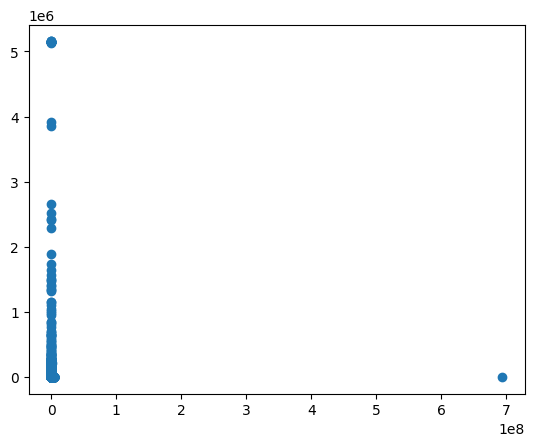

In [78]:
plt.scatter(src_np[1:], dst_np[1:])

#for i in range(len(bCent_ultimate.value)):
 #   plt.scatter(bCent_ultimate.value[i]["src_bytes"],bCent_ultimate.value[i]["dst_bytes"],color='black')


In [ ]:
'''
- Prendere la lista dei centroidi e farla diventare un distributed dataset
- Fare una NUOVA lista di centroidi 
- for i in range(k):
    pesca un singolo dato con probabilità d(x)/phi --> come fare?
    aggiungilo alla lista

'''

# TO DO:
    - Capire come scegliere l
    - Fare la normalizzazione dei dati (se la facciamo)
    - Capire se abbiamo ottimizzato nel modo giusto
    - Implementare tutto k means (optional)
    - Creare un file gemello con un dataframe visualizzabile e vedere se ha senso
    - Iniziare a fare i benchmark su cloud veneto
    - Grafici etc...

# Stop worker and master
Stop the running Spark context (sc) and Spark session (spark)

In [ ]:
# sc.stop()
# spark.stop()

Finally, use `docker compose down` to stop and clear all running containers.